# Pandemic Flu Spread <br>
### Jonah Maroszek <br>

### Prompt (Delete Me)
Consider a classroom of **21 elementary school kids. 20 of the kids are healthy** (and susceptible to flu) on Day 1. Tommy (the 21st kid) walks in with the flu and starts interacting with his potential victims. <br>

To keep things simple, let’s suppose that **Tommy comes to school every day (whether or not he’s sick)** and will be infectious for **3 days** Thus, there are 3 chances for Tommy to infect the other kids — Days 1, 2, and 3. <br>

Suppose that the probability that he infects any individual susceptible kid on any of the three days is **p = 0.02**; and suppose that **all kids and days are independent** (so that you have **i.i.d. Bern(p) trials**). <br>

**If a kid gets infected by Tommy, he will then become infectious for 3 days as well,starting on the next day.** <br>

# Introduction 
## Assumptions <br>
<ul>
  <li>Each sick kid has the same chance of infecting healthy kids as tommy: 0.02</li>
  <li>Each kid gets sick for the same duration tommy does: 3 days </li>
  <li>Tommy is included in the count of sick kids</li>
  <li> After a kid gets sick and recovers, they are not susceptible to infection again </li>
  <li> The simulation is over when no one is susceptable to infection  </li>
</ul>

# Simulation 
## Enter Simulation Parameters 


In [45]:
n_kids = 21 #including tommy
n_simulations = 1000
infection_rate = 0.02

## Imports

In [46]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dataclasses import dataclass

## Define Classes for Kid and Classroom

In [47]:
@dataclass
class Kid:
    infectable: bool = True
    immune: int = False
    day_infected: int = None
    recovery_time: int = 3 

    #determine if kid is healthy, infected, or immune
    def check_up(self, day):
        if self.day_infected == None:
            return
        elif (day - self.day_infected) <= self.recovery_time: 
            self.infectable = False
        else:
            self.immune = True
            self.infectable = False
        
@dataclass
class Classroom:
    members: list[Kid]
    size: int = None
    n_infectable: int = None
    n_sick: int = None
    n_immune: int = None
    infection_rate: float = None

    def __post_init__(self):
        self.size = len(self.members)
        self.n_infectable = sum([1 if kid.infectable else 0 for kid in self.members])
        self.n_sick = self.size - self.get_n_infectable()
        self.n_immune = self.get_n_immune()
        self.infection_rate = self.get_infection_rate()

    def get_n_infectable(self):
        return sum([1 if kid.infectable else 0 for kid in self.members])
    
    def get_n_immune(self):
        return sum([1 if kid.immune else 0 for kid in self.members])
    
    def get_infection_rate(self):
        return min(self.n_sick * infection_rate, 1)
    
    def infect_kids(self, n_infect, day):
        for kid in self.members:
            if kid.infectable and n_infect > 0:
                kid.day_infected = day
                n_infect -= 1
            kid.check_up(day) #update kids health status 

    def update(self):
        self.n_infectable = sum([1 if kid.infectable else 0 for kid in self.members])
        self.n_sick = self.size - (self.get_n_infectable() + self.get_n_immune())
        self.n_immune = self.get_n_immune()
        self.infection_rate = self.get_infection_rate()

# Simulate Epidemics

In [48]:
def setup_classroom(n_kids):
    kids = [Kid() for i in range(n_kids - 1)]
    kids.append(Kid(infectable = False)) #Tommy
    return Classroom(kids)

def run_epidemic(classroom):
    n_infectable_by_day = []
    n_infected_by_day = []
    n_sick_on_day = [] 
    n_immune_by_day =[]
    day = 0 
    while classroom.n_infectable > 0: 
        n_infected = stats.binom.rvs(classroom.n_infectable, classroom.infection_rate)
        classroom.infect_kids(n_infected, day)
        classroom.update()
        n_infectable_by_day.append(classroom.n_infectable)
        n_infected_by_day.append(classroom.size - classroom.n_infectable)
        n_sick_on_day.append(classroom.n_sick)
        n_immune_by_day.append(classroom.n_immune)
        day += 1
    return {"n_infectable_by_day": n_infectable_by_day, 
            "n_infected_by_day": n_infected_by_day, 
            "n_sick_on_day": n_sick_on_day, 
            "n_immune_by_day": n_immune_by_day}

epidemics = []
for i in range(n_simulations):
    classroom = setup_classroom(n_kids)
    epidemic = run_epidemic(classroom)
    epidemics.append(epidemic)

# Simulation Result Analysis 
DONE: (a) What is the distribution of the number of kids that Tommy infects on Day 1? <br>
DONE: (b) What is the expected number of kids that Tommy infects on Day 1? <br>
DONE: (c) What is the expected number of kids that are infected by Day 2 (you can
count Tommy if you want)? <br>
DONE: (d) Simulate the number of kids that are infected on Days 1,2,. . . . Do this many
times. What are the (estimated) expected numbers of kids that are infected by Day i, i = 1, 2, . . .? <br> 
(e) Produce a histogram detailing how long the “epidemic” will last. <br>

Note that there are various ways you can interpret some of the rules above (though
I’ve tried to be clear). So in order to avoid huge amounts of email, simply state
any assumptions that you feel are appropriate

# Distribution of Kids Infected on Day 1
We know  the exact distribution of kids that tommy infects on day 1 is Binomial(n=20, p=0.02). This gives us an expected number of infections of np = 0.4. The expected number of infections matches closely with the simulation results

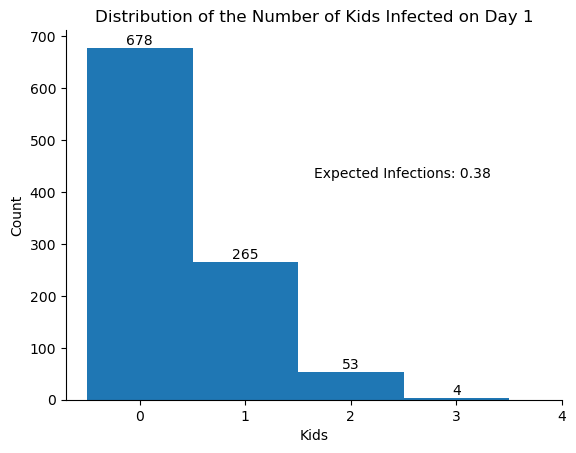

In [60]:
n_infected_day_1 = [epidemic['n_sick_on_day'][0] - 1 for epidemic in epidemics] #the count of sick kids includes tommy, so subtract 1
expected_sick_on_day_1 = np.mean(n_infected_day_1)

fig, ax = plt.subplots()
bins = np.arange(0, 5) 
counts, edges, bars = ax.hist(n_infected_day_1, bins, align='left')
ax.bar_label(bars)
ax.set_xlabel("Kids")
ax.set_ylabel("Count")
ax.set_title("Distribution of the Number of Kids Infected on Day 1")
ax.spines[['right', 'top']].set_visible(False)
ax.set_xticks(bins)
_ = ax.annotate(f"Expected Infections: {np.round(expected_sick_on_day_1, 2)}", xy=(0.5, .6), xycoords="axes fraction") 

# Distribution of Kids Infected by Day 2
Note that since the recovery period is 3 days for each student, all kids infected on day 1 will still be sick on day 2. Tommy will also be sick, but he is not included in the count here. 

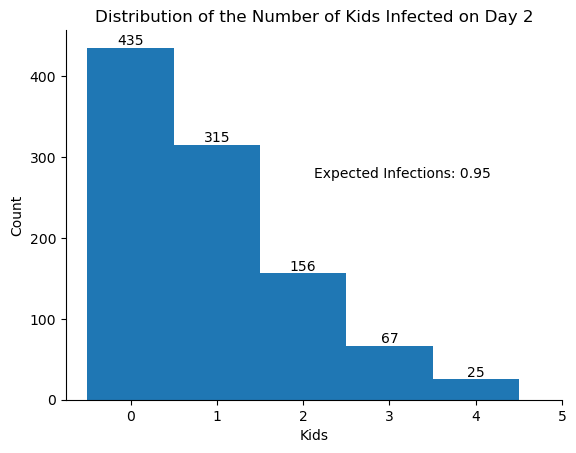

In [61]:
n_infected_day_2 = [epidemic['n_sick_on_day'][1] - 1 for epidemic in epidemics] #the count of sick kids includes tommy, so subtract 1
expected_sick_on_day_2 = np.mean(n_infected_day_2)

fig, ax = plt.subplots()
bins = np.arange(0, 6) 
counts, edges, bars = ax.hist(n_infected_day_2, bins, align='left')
ax.bar_label(bars)
ax.set_xlabel("Kids")
ax.set_ylabel("Count")
ax.set_title("Distribution of the Number of Kids Infected on Day 2")
ax.spines[['right', 'top']].set_visible(False)
ax.set_xticks(bins)
_ = ax.annotate(f"Expected Infections: {np.round(expected_sick_on_day_2, 2)}", xy=(0.5, .6), xycoords="axes fraction") 

# Expected Infections for the First 20 Days
Note this is a cummulative sum of all students that have been infected by day i, even those that have been infected and recovered by day i.

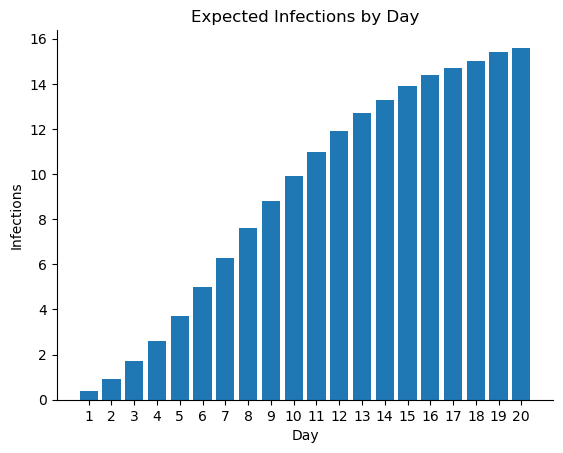

In [119]:
expected_infections_by_day = []
days = 20
for i in range(days):
    infected_by_day_i = []
    for epidemic in epidemics:
        if i <= len(epidemic['n_infected_by_day']) - 1:
            infected_by_day_i.append(epidemic['n_infected_by_day'][i] - 1) #exclude tommy from infection count
        else: #all kids have been infected 
            infected_by_day_i.append(n_kids - 1) 
    expected_infections_by_day.append(np.mean(infected_by_day_i))
    
fig, ax = plt.subplots()
locations = [x + 1 for x in range(days)] 
bars = ax.bar(locations, np.round(expected_infections_by_day, 1))
#_ = ax.bar_label(bars)
ax.set_xlabel("Day")
ax.set_ylabel("Infections")
ax.set_title("Expected Infections by Day")
ax.spines[['right', 'top']].set_visible(False)
_ = ax.set_xticks(locations)

# Final Conclusions 